In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

! pip install netcdf4
! pip install Basemap
#! pip install geopandas
! pip install cartopy
#! pip install rasterio
#! pip install rasterstats
! pip install numpy
! pip install pandas
#! pip install shapely
#! pip install pygeos
#! pip install rtree
! pip install xarray
! pip install intake-esm


In [6]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
#import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
#import rasterio as rio
#from rasterio.plot import show
#import rasterstats
from affine import Affine
import cartopy.crs as ccrs
#from rasterstats import zonal_stats
#import pygeos
#import rtree
import xarray as xr
import numpy.ma as ma

In [ ]:
data_dir = "drive/MyDrive/Colab Notebooks/capstone/"
fn = '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20500101-20591231_combined.nc'
ds = nc.Dataset(fn)
print(ds.variables)

In [ ]:
ds.variables.keys()

dict_keys(['time', 'time_bnds', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'height', 'tas'])

In [ ]:
time_variable = ds['time']
lat = ds.variables['lat'][:]
lon = ds.variables['lon'][:]
tas = ds.variables['tas'][:]
print(tas.shape)

[12784.5 12785.5 12786.5 12787.5 12788.5 12789.5 12790.5 12791.5 12792.5
 12793.5]


In [ ]:
#global attributes of the dataset
print(ds.ncattrs())
for attr in ds.ncattrs():
  print(f'{attr}: {ds.getncattr(attr)}')


['Conventions', 'activity_id', 'branch_method', 'branch_time_in_child', 'branch_time_in_parent', 'creation_date', 'data_specs_version', 'experiment', 'experiment_id', 'external_variables', 'forcing_index', 'frequency', 'further_info_url', 'grid', 'grid_label', 'history', 'initialization_index', 'institution', 'institution_id', 'mip_era', 'nominal_resolution', 'parent_activity_id', 'parent_experiment_id', 'parent_mip_era', 'parent_source_id', 'parent_time_units', 'parent_variant_label', 'physics_index', 'product', 'realization_index', 'realm', 'source', 'source_id', 'source_type', 'sub_experiment', 'sub_experiment_id', 'table_id', 'table_info', 'title', 'variable_id', 'variant_label', 'license', 'cmor_version', 'tracking_id']
Conventions: CF-1.7 CMIP-6.2
activity_id: ScenarioMIP
branch_method: standard
branch_time_in_child: 0.0
branch_time_in_parent: 60265.0
creation_date: 2019-07-26T12:12:54Z
data_specs_version: 01.00.27
experiment: update of RCP8.5 based on SSP5
experiment_id: ssp585


In [ ]:
# Reshape the 'tas' variable to 2D
num_time_steps, num_lat, num_lon = tas.shape
tas_2d = tas.reshape(num_time_steps, num_lat * num_lon)
df = pd.DataFrame(tas_2d, columns=[f'Grid_{i}' for i in range(num_lat * num_lon)])
df['Latitude'] = lat[0]
df['Longitude'] = lon[0]
print(df)

          Grid_0      Grid_1      Grid_2      Grid_3      Grid_4      Grid_5  \
0     249.995132  249.211044  248.847458  249.789032  249.767075  249.355057   
1     250.811920  250.634079  250.700211  250.639236  250.652649  250.711563   
2     251.205276  251.079910  251.144989  251.155075  251.203583  251.218002   
3     250.744690  250.937820  250.459442  250.865555  250.757385  250.935120   
4     251.828842  251.779556  251.571335  251.861588  252.112671  251.932266   
...          ...         ...         ...         ...         ...         ...   
3647  247.151474  247.152969  247.166336  247.183212  247.202286  247.035614   
3648  247.546494  247.538315  247.545868  247.540405  247.560028  247.474503   
3649  245.428528  245.411072  245.413605  245.395844  245.414719  245.338745   
3650  244.389496  244.374649  244.380005  244.363571  244.385712  244.318802   
3651  245.306808  245.294632  245.306519  245.292084  245.324692  245.253220   

          Grid_6      Grid_7      Grid_

In [ ]:
temperature = ds['tas']
print(temperature)

<class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    _FillValue: 1e+20
    standard_name: air_temperature
    long_name: Near-Surface Air Temperature
    comment: near-surface (usually, 2 meter) air temperature
    units: K
    original_name: temp2
    cell_methods: area: time: mean
    cell_measures: area: areacella
    history: 2019-07-26T12:12:54Z altered by CMOR: Treated scalar dimension: 'height'. 2019-07-26T12:12:54Z altered by CMOR: replaced missing value flag (-9e+33) with standard missing value (1e+20). 2019-07-26T12:12:54Z altered by CMOR: Inverted axis: lat.
    coordinates: height
    missing_value: 1e+20
unlimited dimensions: time
current shape = (3652, 192, 384)
filling on


DECADAL ANALYSIS

In [ ]:
#create decadal average file(2015-2024)
file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20150101-20151231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20160101-20161231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20170101-20171231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20180101-20181231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20190101-20191231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20200101-20201231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20210101-20211231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20220101-20221231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20230101-20231231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20240101-20241231.nc'
]

datasets = [xr.open_dataset(file_path) for file_path in file_paths]
combined_dataset = xr.concat(datasets, dim='time')

decadal_average = combined_dataset['tas'].mean(dim='time')

output_path = '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/2015-2024_decadal_average.nc'
decadal_average.to_netcdf(output_path)

for ds in datasets:
    ds.close()



In [ ]:
#create decadal average file(2050-2059)
file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20500101-20501231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20510101-20511231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20520101-20521231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20530101-20531231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20540101-20541231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20550101-20551231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20560101-20561231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20570101-20571231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20580101-20581231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20590101-20591231.nc'
]

datasets = [xr.open_dataset(file_path) for file_path in file_paths]
combined_dataset = xr.concat(datasets, dim='time')

decadal_average = combined_dataset['tas'].mean(dim='time')

output_path = '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/2050-2059_decadal_average.nc'
decadal_average.to_netcdf(output_path)

for ds in datasets:
    ds.close()



In [ ]:
#create decadal average file(2090-2099)
file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20900101-20901231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20910101-20911231.nc',
   '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20920101-20921231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20930101-20931231.nc',
'/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20940101-20941231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20950101-20951231.nc',
'/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20960101-20961231.nc',
  '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20970101-20971231.nc',
    '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20980101-20981231.nc',
   '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/tas_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20990101-20991231.nc',
]

datasets = [xr.open_dataset(file_path) for file_path in file_paths]
combined_dataset = xr.concat(datasets, dim='time')

decadal_average = combined_dataset['tas'].mean(dim='time')

output_path = '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/2090-2099_decadal_average.nc'
decadal_average.to_netcdf(output_path)

for ds in datasets:
    ds.close()



**2015-2024 tas analysis**



/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


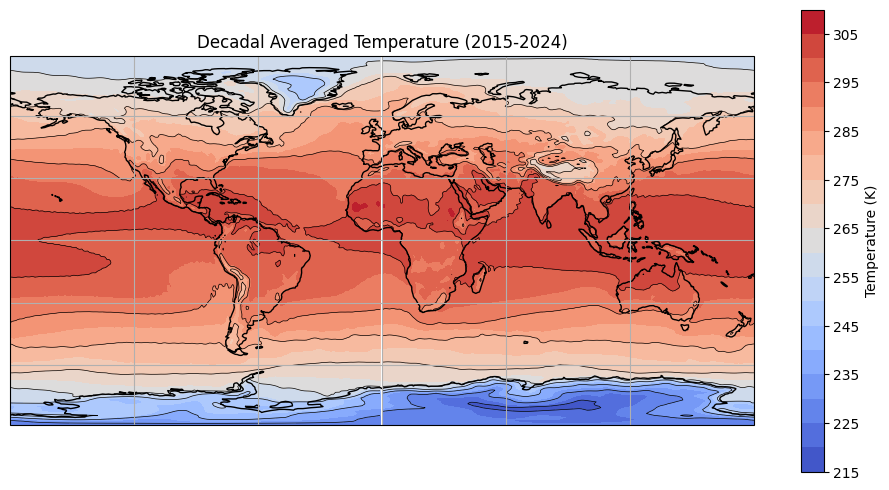

In [10]:

decadal_average_path = '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/2015-2024_decadal_average.nc'
decadal_average = xr.open_dataset(decadal_average_path)

lats = decadal_average['lat']
lons = decadal_average['lon']
tas_values = decadal_average['tas']

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

contour = plt.contourf(lons, lats, tas_values, levels=20, cmap='coolwarm', transform=ccrs.PlateCarree())

contour_lines = plt.contour(lons, lats, tas_values, levels=10, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour)
cbar.set_label('Temperature (K)')

ax.coastlines()
ax.gridlines()

plt.title('Decadal Averaged Temperature (2015-2024)')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

plt.show()


**2050-2059 analysis**

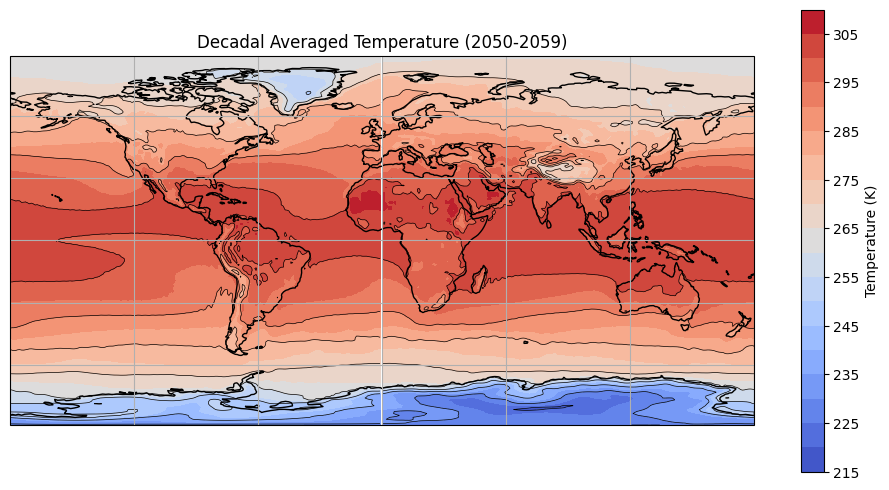

In [12]:

decadal_average_path = '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/2050-2059_decadal_average.nc'
decadal_average= xr.open_dataset(decadal_average_path)

lats = decadal_average['lat']
lons = decadal_average['lon']
tas_values = decadal_average['tas']

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

contour = plt.contourf(lons, lats, tas_values, levels=20, cmap='coolwarm', transform=ccrs.PlateCarree())

contour_lines = plt.contour(lons, lats, tas_values, levels=10, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour)
cbar.set_label('Temperature (K)')

ax.coastlines()
ax.gridlines()

plt.title('Decadal Averaged Temperature (2050-2059)')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

plt.show()


**2090-2099 tas analysis**



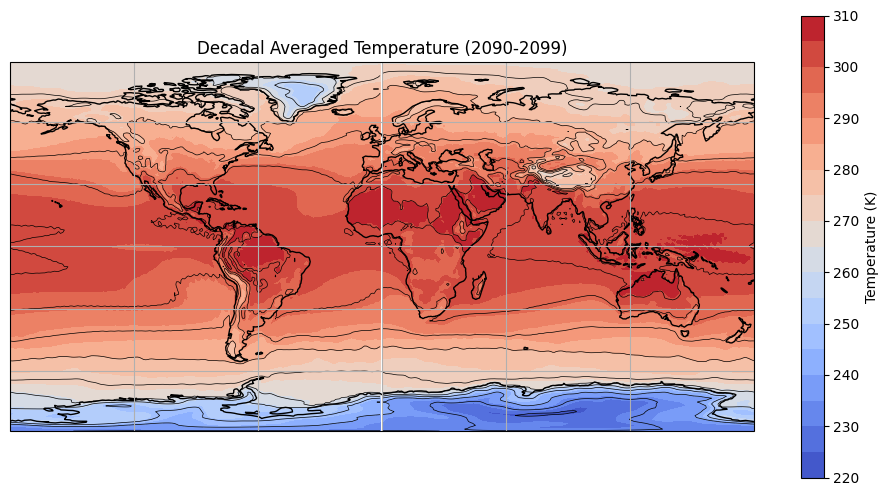

In [13]:

decadal_average_path = '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/2090-2099_decadal_average.nc'
decadal_average= xr.open_dataset(decadal_average_path)

lats = decadal_average['lat']
lons = decadal_average['lon']
tas_values = decadal_average['tas']

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

contour = plt.contourf(lons, lats, tas_values, levels=20, cmap='coolwarm', transform=ccrs.PlateCarree())

contour_lines = plt.contour(lons, lats, tas_values, levels=10, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour)
cbar.set_label('Temperature (K)')

ax.coastlines()
ax.gridlines()

plt.title('Decadal Averaged Temperature (2090-2099)')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

plt.show()


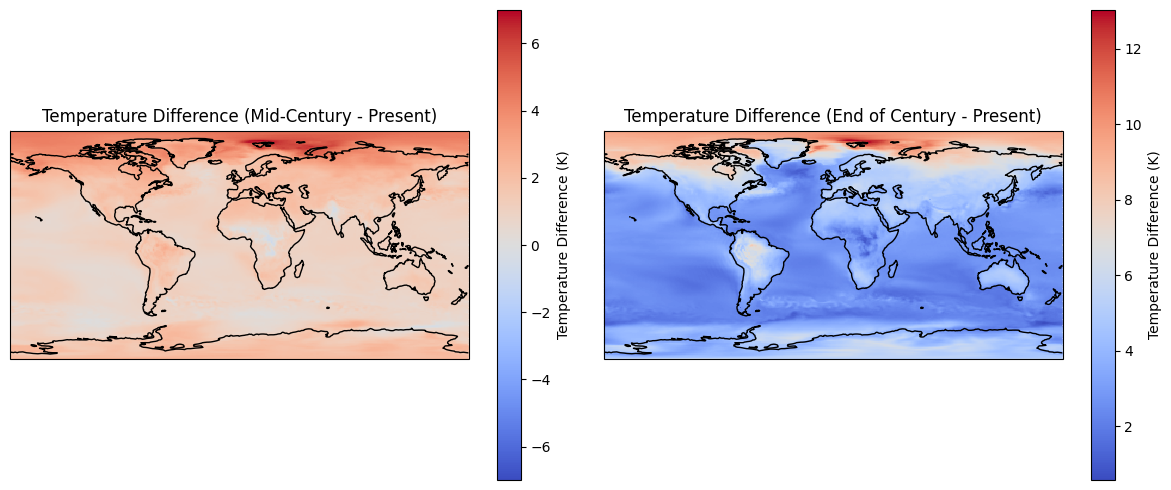

In [14]:

decadal_average_path_1 = '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/2015-2024_decadal_average.nc'
ds_present  = xr.open_dataset(decadal_average_path_1)
decadal_average_path_2 = '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/2050-2059_decadal_average.nc'
ds_mid_century = xr.open_dataset(decadal_average_path_2)
decadal_average_path_3 = '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/2090-2099_decadal_average.nc'
ds_end_of_century = xr.open_dataset(decadal_average_path_3)

temp_diff_mid_century =  ds_mid_century['tas'] - ds_present['tas']
temp_diff_end_of_century =   ds_end_of_century['tas'] - ds_present['tas']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

temp_diff_mid_century.plot(ax=ax1, cmap='coolwarm', cbar_kwargs={'label': 'Temperature Difference (K)'})
ax1.set_title('Temperature Difference (Mid-Century - Present)')

temp_diff_end_of_century.plot(ax=ax2, cmap='coolwarm', cbar_kwargs={'label': 'Temperature Difference (K)'})
ax2.set_title('Temperature Difference (End of Century - Present)')

ax1.coastlines()
ax2.coastlines()

plt.tight_layout()
plt.show()




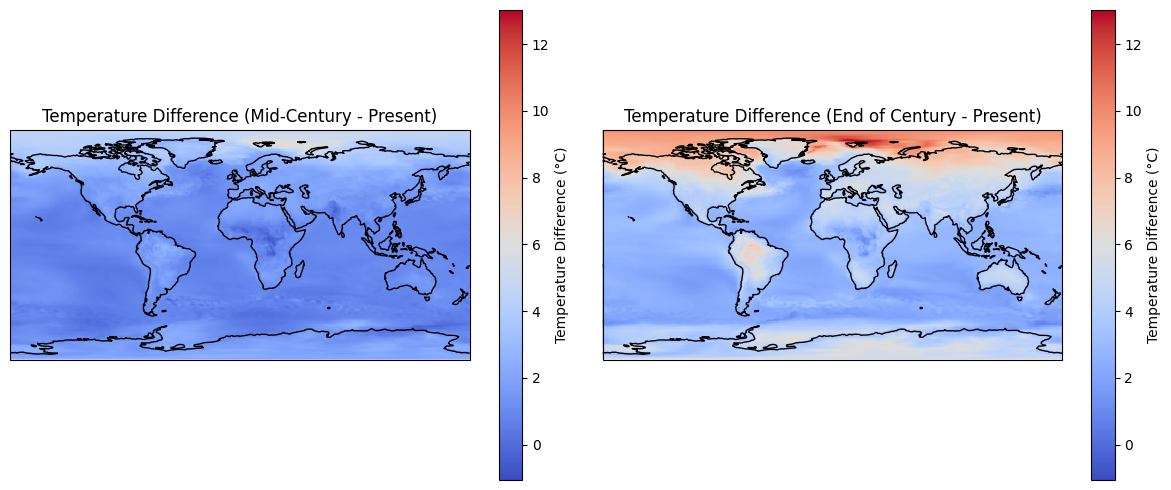

In [15]:
decadal_average_path_1 = '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/2015-2024_decadal_average.nc'
ds_present  = xr.open_dataset(decadal_average_path_1)
decadal_average_path_2 = '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/2050-2059_decadal_average.nc'
ds_mid_century = xr.open_dataset(decadal_average_path_2)
decadal_average_path_3 = '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/2090-2099_decadal_average.nc'
ds_end_of_century = xr.open_dataset(decadal_average_path_3)

temp_diff_mid_century =  ds_mid_century['tas'] - ds_present['tas']
temp_diff_end_of_century =   ds_end_of_century['tas'] - ds_present['tas']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})

vmin = min(temp_diff_mid_century.min(), temp_diff_end_of_century.min())
vmax = max(temp_diff_mid_century.max(), temp_diff_end_of_century.max())

temp_diff_mid_century.plot(ax=ax1, cmap='coolwarm', cbar_kwargs={'label': 'Temperature Difference (°C)'}, vmin=vmin, vmax=vmax)
ax1.set_title('Temperature Difference (Mid-Century - Present)')

temp_diff_end_of_century.plot(ax=ax2, cmap='coolwarm', cbar_kwargs={'label': 'Temperature Difference (°C)'}, vmin=vmin, vmax=vmax)
ax2.set_title('Temperature Difference (End of Century - Present)')

ax1.coastlines()
ax2.coastlines()

plt.tight_layout()
plt.show()




**CSV file with tas changes from present to mid and present to end centuries**

In [ ]:
import os

decadal_average_path_1 = '/content/drive/MyDrive/Colab Notebooks/capstone/2015-2024/2015-2024_decadal_average.nc'
ds_present  = xr.open_dataset(decadal_average_path_1)
decadal_average_path_2 = '/content/drive/MyDrive/Colab Notebooks/capstone/2050-2059/2050-2059_decadal_average.nc'
ds_mid_century = xr.open_dataset(decadal_average_path_2)
decadal_average_path_3 = '/content/drive/MyDrive/Colab Notebooks/capstone/2090-2099/2090-2099_decadal_average.nc'
ds_end_of_century = xr.open_dataset(decadal_average_path_3)

temp_diff_mid_century =  ds_mid_century['tas'] - ds_present['tas']
temp_diff_end_of_century =   ds_end_of_century['tas'] - ds_present['tas']

temp_diff_mid_century_flat = temp_diff_mid_century.values.flatten()
temp_diff_end_of_century_flat = temp_diff_end_of_century.values.flatten()

data = {
    'Grid_ID': np.arange(len(temp_diff_mid_century_flat)),
    'Temperature_Difference_Mid_Century': temp_diff_mid_century_flat,
    'Temperature_Difference_End_of_Century': temp_diff_end_of_century_flat
}

df = pd.DataFrame(data)

output_dir = '/content/drive/MyDrive/Colab Notebooks/capstone/'
output_file = os.path.join(output_dir, 'temperature_changes.csv')

df.to_csv(output_file, index=False)



In [ ]:
gdf = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/capstone/ne_10m_admin_0_countries.zip")

gdf.plot()

plt.title('Map Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
